In [12]:
%pylab inline
import numpy as np
import imageio
import scipy.ndimage as ndi

pylab.rcParams['figure.figsize'] = (10, 10)

Populating the interactive namespace from numpy and matplotlib


In [13]:
bearImage = imageio.imread('./data/bear.png') / 255.0
bearMask = imageio.imread('./data/mask.png') / 255.0 > 0.5
bgImage = imageio.imread('./data/waterpool.png') / 255.0

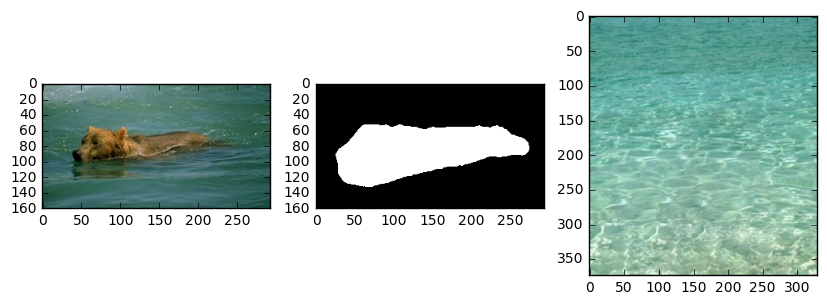

In [14]:
subplot(1, 3, 1)
imshow(bearImage)
subplot(1, 3, 2)
imshow(bearMask)
subplot(1, 3, 3)
imshow(bgImage)

/opt/killavus/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 161 but corresponding boolean dimension is 160


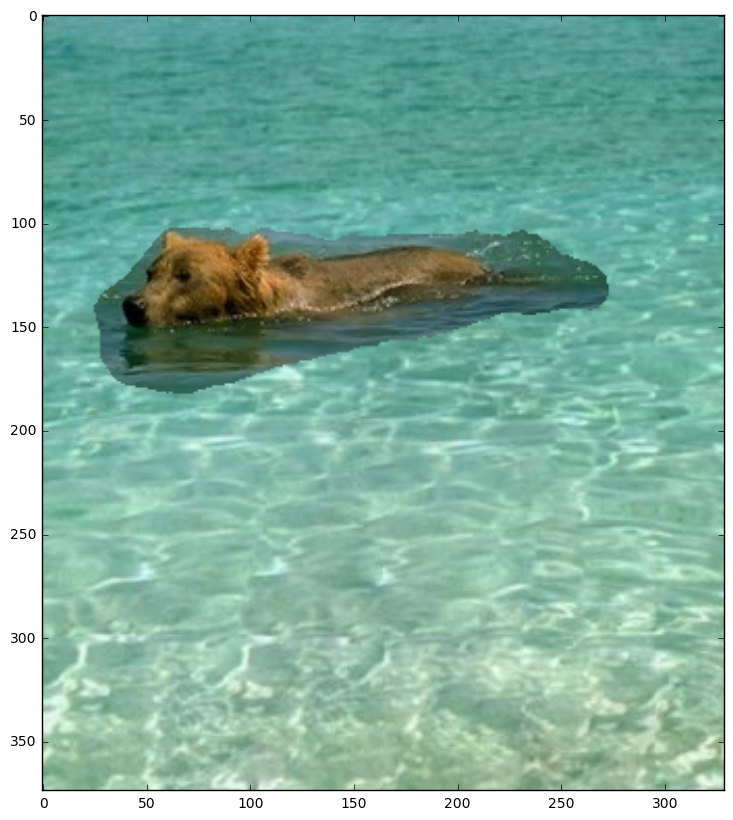

In [15]:
def naiveComposite(bg, fg, mask, y, x):
    h = min(fg.shape[0], bg.shape[0] - y)
    w = min(fg.shape[1], bg.shape[1] - x)
        
    result = np.copy(bg)
    composite = result[y:(y+h+1),x:(x+w+1)]
    composite[mask[:h,:w] != 0] = fg[mask[:h,:w] != 0]    
    
    return result

imshow(naiveComposite(bgImage, bearImage, bearMask, 50, 0))

In [16]:
def im_dot(x, y):
    return (x * y).sum()

def laplacian_operator(img):
    L = np.array([
        [ 0.0, -1.0,  0.0],
        [-1.0,  4.0, -1.0],
        [ 0.0, -1.0,  0.0]
    ])
    
    return np.dstack([
        ndi.convolve(img[:, :, 0], L),
        ndi.convolve(img[:, :, 1], L),
        ndi.convolve(img[:, :, 2], L)
    ])

def poissonCompositing(bg, fg, mask, niter, y, x):
    h = min(fg.shape[0], bg.shape[0] - y)
    w = min(fg.shape[1], bg.shape[1] - x)
    
    big_fg = np.zeros_like(bg)
    big_mask = np.zeros(bg.shape).astype(mask.dtype)
    
    big_fg[y:(y+h),x:(x+w)] = fg
    big_mask[y:(y+h),x:(x+w)] = mask
    
    big_mask_3d = big_mask
    
    if big_mask_3d.shape[2] != 3:
        big_mask_3d = np.dstack([big_mask, big_mask, big_mask])
        
    big_mask_3d[big_mask_3d == 255] = 1
        
    cbg = bg.copy()
    cbg[big_mask_3d] = False
            
    b = laplacian_operator(big_fg)
    x = cbg + (big_fg * big_mask_3d)
        
    for i in range(niter):
        r = (b - laplacian_operator(x)) * big_mask_3d
        a = im_dot(r, r) / im_dot(r, laplacian_operator(r))
        x = x + a * r
      
    return x

def poissonCGCompositing(bg, fg, mask, niter, y, x):
    h = min(fg.shape[0], bg.shape[0] - y)
    w = min(fg.shape[1], bg.shape[1] - x)
    
    big_fg = np.zeros_like(bg)
    big_mask = np.zeros(bg.shape).astype(mask.dtype)
    
    big_fg[y:(y+h),x:(x+w)] = fg
    big_mask[y:(y+h),x:(x+w)] = mask
    
    big_mask_3d = big_mask
    
    if big_mask_3d.shape[2] != 3:
        big_mask_3d = np.dstack([big_mask, big_mask, big_mask])
                
    cbg = bg.copy()
    cbg[big_mask_3d] = False
            
    b = laplacian_operator(big_fg)
    x = cbg + (big_fg * big_mask_3d)
    r = (b - laplacian_operator(x)) * big_mask_3d
    d = r
        
    for i in range(niter):
        a = im_dot(r, r) / im_dot(d, laplacian_operator(d))
        x = x + a*d
        next_r = (r - a * laplacian_operator(d)) * big_mask_3d
        b = im_dot(next_r, next_r) / im_dot(r, r)
        r = next_r
        d = (r + b * d) * big_mask_3d
        
    return x

In [18]:
for niter in [0, 50, 100, 200, 500, 1000, 2000]:
    print "Bear Poisson niter = %d" % niter
    imageio.imsave("bear_poisson_%04d.png" % niter, np.clip(poissonCompositing(bgImage, bearImage, bearMask, niter, 50, 0), 0, 1))

for niter in [0, 50, 100, 200, 500, 1000, 2000]:
    print "Bear Poisson CG niter = %d" % niter
    imageio.imsave("bear_poisson_cg_%05d.png" % niter, np.clip(poissonCGCompositing(bgImage, bearImage, bearMask, niter, 50, 0), 0, 1))

Bear Poisson niter = 0
Bear Poisson niter = 50
Bear Poisson niter = 100
Bear Poisson niter = 200
Bear Poisson niter = 500
Bear Poisson niter = 1000
Bear Poisson niter = 2000
Bear Poisson CG niter = 0
Bear Poisson CG niter = 50
Bear Poisson CG niter = 100
Bear Poisson CG niter = 200
Bear Poisson CG niter = 500
Bear Poisson CG niter = 1000
Bear Poisson CG niter = 2000
